In [1]:
import pandas as pd
import numpy as np
import dateutil.parser as dp
from datetime import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

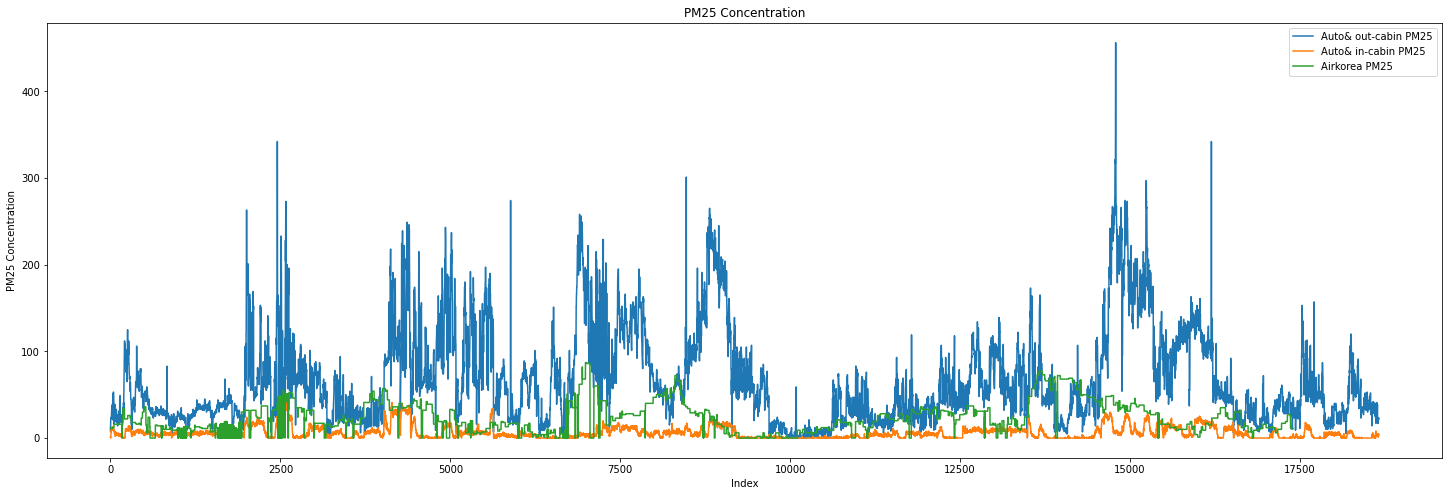

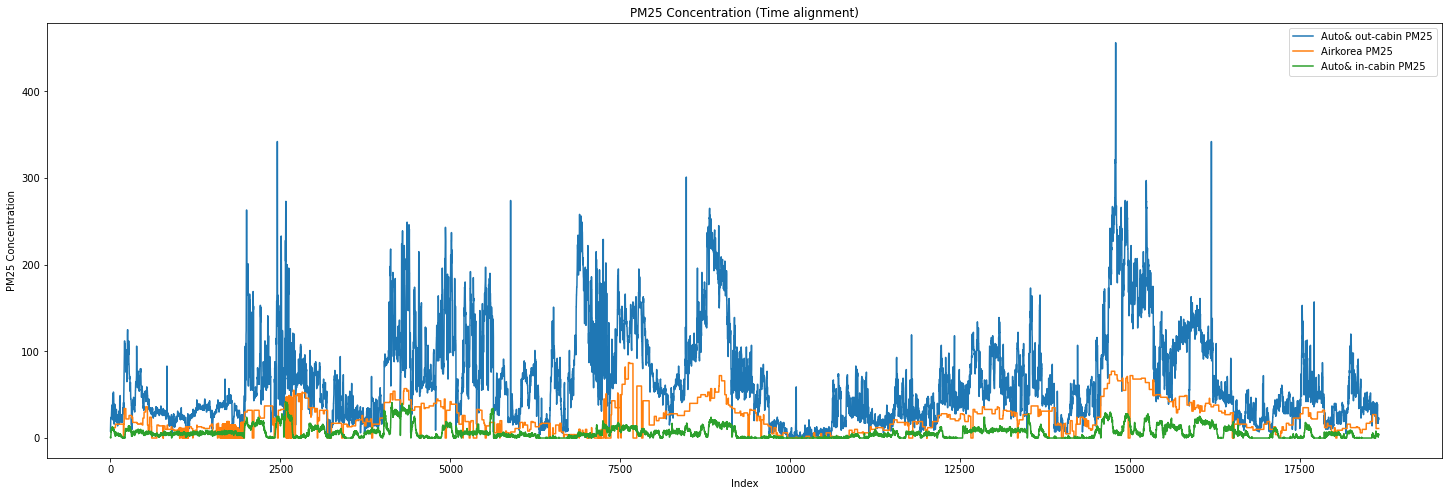

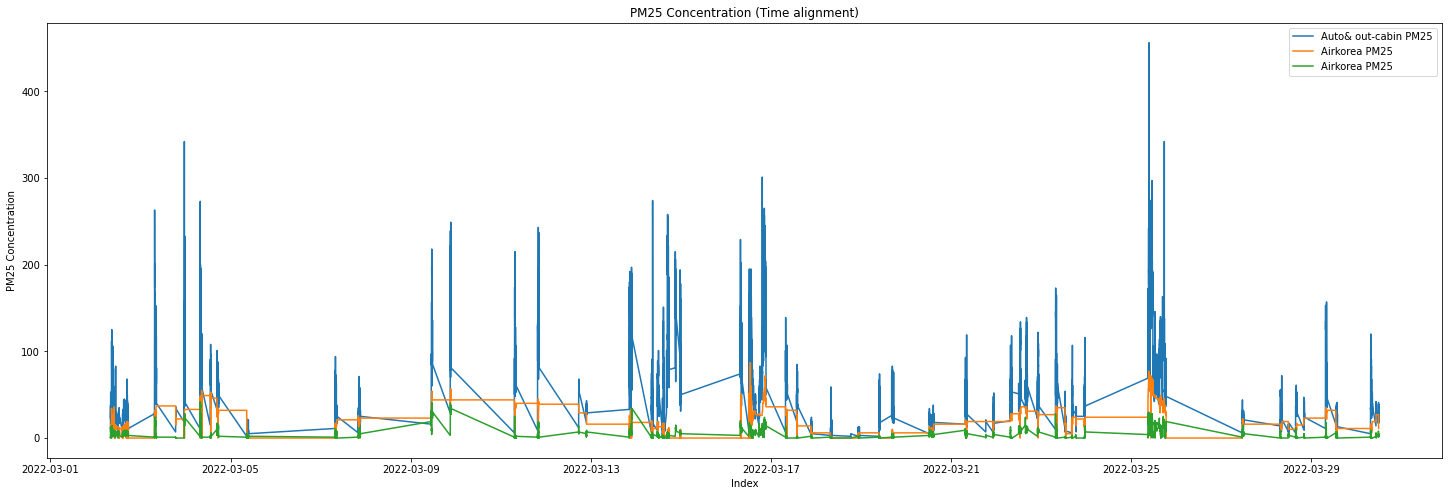

In [7]:

# Load Data
auton_out_pm25_file = "./data/44_2022-3-1_2022-3-31_auton_pm25_out.xlsx"
auton_in_pm25_file = "./data/44_2022-3-1_2022-3-31_auton_pm25_in.xlsx"
airkorea_out_pm25_file = "./data/44_2022-3-1_2022-3-31_airkorea_pm25.xlsx"

auton_out_pm25 = pd.read_excel(auton_out_pm25_file, parse_dates=['date'], header=0)
auton_in_pm25 = pd.read_excel(auton_in_pm25_file, parse_dates=['date'], header=0)
airkorea_out_pm25 = pd.read_excel(airkorea_out_pm25_file, parse_dates=['date'], header=0)


auton_out_pm25_t = pd.read_excel(auton_out_pm25_file, header=0, parse_dates=['date'], index_col="date")
auton_in_pm25_t = pd.read_excel(auton_in_pm25_file, header=0, parse_dates=['date'], index_col="date")
airkorea_out_pm25_t = pd.read_excel(airkorea_out_pm25_file, header=0, parse_dates=['date'], index_col="date")

# apply column names
# auton_out_pm25.columns = ['date', 'auton_out_pm25']
# auton_in_pm25.columns = ['date', 'auton_in_pm25']
# airkorea_out_pm25.columns = ['date', 'airkorea_out_pm25']

# Visualize Data (PM25, without aligned, without time-indexed)
plt.plot(auton_out_pm25['auton_pm25'], label="Auto& out-cabin PM25")
plt.plot(auton_in_pm25['auton_pm25'], label="Auto& in-cabin PM25")
plt.plot(airkorea_out_pm25['airkorea_pm25'], label="Airkorea PM25")
plt.rcParams["figure.figsize"] = (25,8)
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Concentration")
plt.show()

# merge (with aligned, without time-indexed)
aligned_pm25 = pd.merge_asof(auton_out_pm25, airkorea_out_pm25, on='date')
aligned_pm25['auton_pm25_incabin'] = auton_in_pm25['auton_pm25']
plt.plot(aligned_pm25['auton_pm25'], label="Auto& out-cabin PM25")
plt.plot(aligned_pm25['airkorea_pm25'], label="Airkorea PM25")
plt.plot(aligned_pm25['auton_pm25_incabin'], label="Auto& in-cabin PM25")
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Concentration (Time alignment)")
plt.show()

# Visualization (x axis : time)
plt.plot(aligned_pm25['date'], aligned_pm25['auton_pm25'], label="Auto& out-cabin PM25")
plt.plot(aligned_pm25['date'], aligned_pm25['airkorea_pm25'], label="Airkorea PM25")
plt.plot(aligned_pm25['date'], aligned_pm25['auton_pm25_incabin'], label="Airkorea PM25")
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Concentration (Time alignment)")
plt.show()


auton : 67.24013933547695/54.32043175206877
airkorea : 25.9720136928713/16.57197416817572
mean: 67.24013933547695


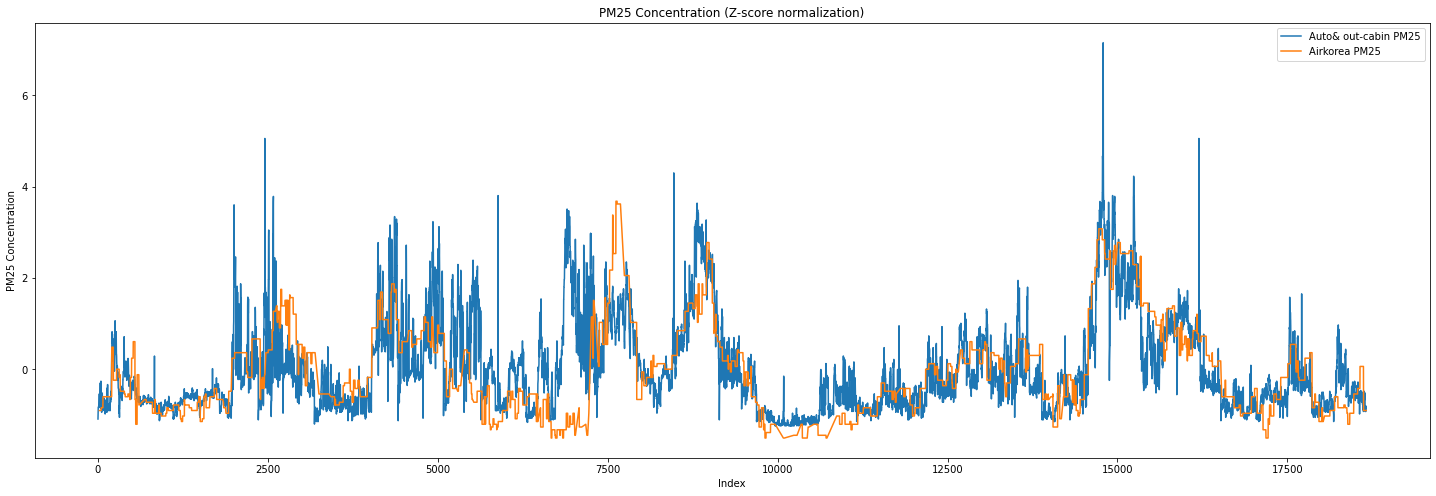

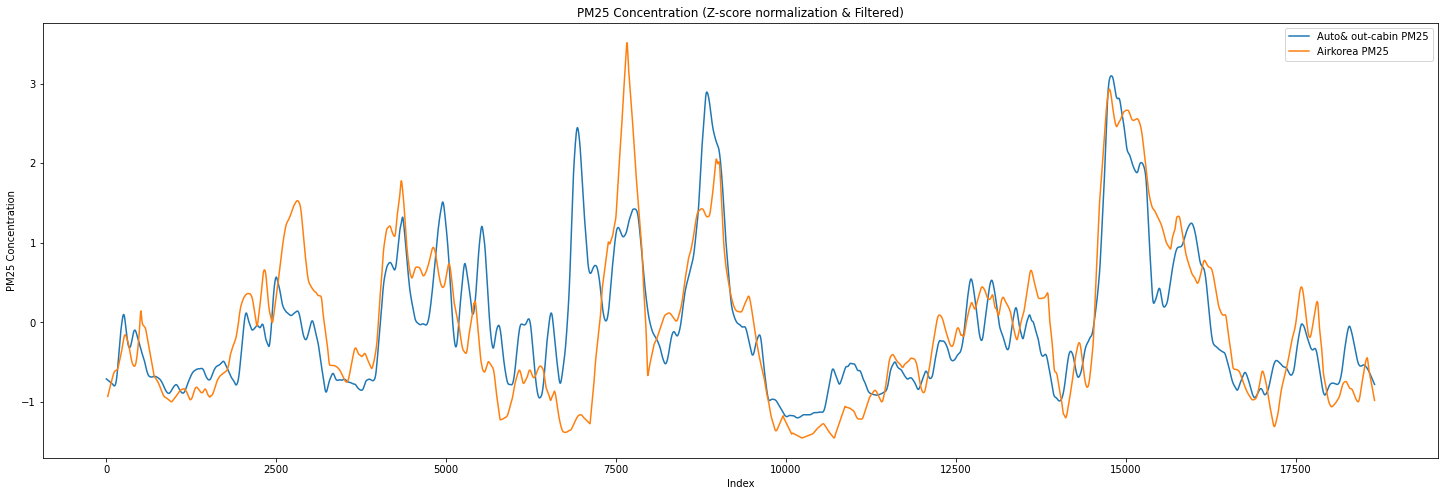

* Aligned PM25 Data shape : (18660, 8)
* Auton PM25 Mean : 67.24013933547695
* Auton PM25 Std : 54.32043175206877
* Airkorea PM25 Mean : 25.9720136928713
* Airkorea PM25 Std : 16.57197416817572


In [9]:
# visualization standardization (z-score normalization)
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# zero count to replace the 0 to NaN for airkorea data
aligned_pm25["airkorea_pm25"] = aligned_pm25["airkorea_pm25"].replace(0,np.NaN)
#aligned_pm25["auton_pm25"] = aligned_pm25["auton_pm25"].replace(0,np.NaN)
#print(aligned_pm25.isin([0]).sum(axis=0))

airkorea_pm25_z = stats.zscore(aligned_pm25["airkorea_pm25"].dropna())
auton_pm25_z = stats.zscore(aligned_pm25["auton_pm25"].dropna())
aligned_pm25["auton_pm25_z"] = auton_pm25_z
aligned_pm25["airkorea_pm25_z"] = airkorea_pm25_z

auton_pm25_mean = aligned_pm25["auton_pm25"].dropna().mean()
auton_pm25_std = aligned_pm25["auton_pm25"].dropna().std()
airkorea_pm25_mean = aligned_pm25["airkorea_pm25"].dropna().mean()
airkorea_pm25_std = aligned_pm25["airkorea_pm25"].dropna().std()

print("auton : {}/{}".format(auton_pm25_mean, auton_pm25_std))
print("airkorea : {}/{}".format(airkorea_pm25_mean, airkorea_pm25_std))

# Visualization (standardization)
plt.plot(auton_pm25_z, label="Auto& out-cabin PM25")
plt.plot(airkorea_pm25_z, label="Airkorea PM25")
plt.rcParams["figure.figsize"] = (25,8)
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Concentration (Z-score normalization)")
plt.show()

# LOWESS Filtering
auton_filtered = lowess(auton_pm25_z.values, auton_pm25_z.index.values, frac=0.01)
index, data = np.transpose(auton_filtered)
auton_pm25_z_filtered = pd.Series(data, index=index.astype(int))

airkorea_filtered = lowess(airkorea_pm25_z.values, airkorea_pm25_z.index.values, frac=0.01)
index, data = np.transpose(airkorea_filtered)
airkorea_pm25_z_filtered = pd.Series(data, index=index.astype(int))

aligned_pm25["airkorea_pm25_z_filtered"] = airkorea_pm25_z_filtered
aligned_pm25["auton_pm25_z_filtered"] = auton_pm25_z_filtered

#Visualization (standardization)
plt.plot(auton_pm25_z_filtered, label="Auto& out-cabin PM25")
plt.plot(airkorea_pm25_z_filtered, label="Airkorea PM25")
plt.rcParams["figure.figsize"] = (25,8)
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Concentration (Z-score normalization & Filtered)")
plt.show()

# Data Info
#print(aligned_pm25)
print("* Aligned PM25 Data shape : {}".format(aligned_pm25.shape))
print("* Auton PM25 Mean : {}".format(auton_pm25_mean))
print("* Auton PM25 Std : {}".format(auton_pm25_std))
print("* Airkorea PM25 Mean : {}".format(airkorea_pm25_mean))
print("* Airkorea PM25 Std : {}".format(airkorea_pm25_std))



PLCC :
                auton_pm25  airkorea_pm25
auton_pm25       1.000000       0.772614
airkorea_pm25    0.772614       1.000000
(0.7726143476718048, 0.0)
SROCC :
                auton_pm25  airkorea_pm25
auton_pm25       1.000000       0.758417
airkorea_pm25    0.758417       1.000000
SpearmanrResult(correlation=0.7584174987177925, pvalue=0.0)
Kendall :
                auton_pm25  airkorea_pm25
auton_pm25       1.000000       0.589341
airkorea_pm25    0.589341       1.000000
KendalltauResult(correlation=0.5893406252327639, pvalue=0.0)


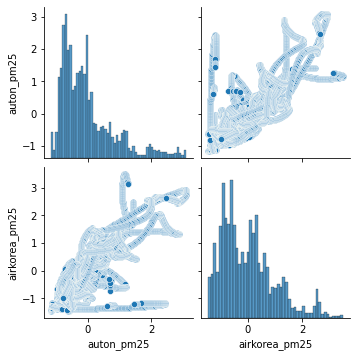

In [4]:
# pearson correlation with airkorea and auton data
source = pd.DataFrame()
source['date'] = aligned_pm25['date'].copy()
source['auton_pm25'] = auton_pm25_z_filtered
source['airkorea_pm25'] = airkorea_pm25_z_filtered
source = source.dropna()
sns.pairplot(data=source)


corr_pearson = source.corr(method='pearson')
print('PLCC :\n', corr_pearson)
print(stats.pearsonr(source['auton_pm25'], source['airkorea_pm25']))

corr_spearman = source.corr(method='spearman')
print('SROCC :\n', corr_spearman)
print(stats.spearmanr(source['auton_pm25'], source['airkorea_pm25']))

corr_kendall = source.corr(method='kendall')
print('Kendall :\n', corr_kendall)
print(stats.kendalltau(source['auton_pm25'], source['airkorea_pm25']))



R-squared : 0.6976843900446925


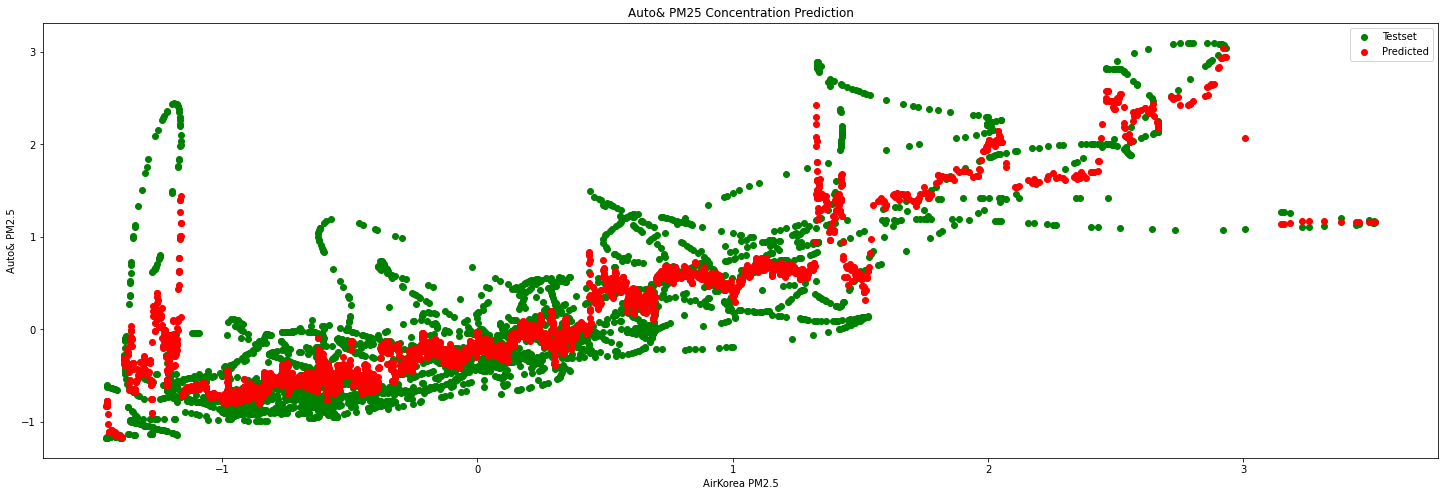

Data Columns : Index(['date', 'auton_pm25', 'airkorea_pm25', 'auton_pm25_incabin',
       'auton_pm25_z', 'airkorea_pm25_z', 'airkorea_pm25_z_filtered',
       'auton_pm25_z_filtered', 'auton_pm25_z_predicted',
       'auton_pm25_zr_predicted'],
      dtype='object')


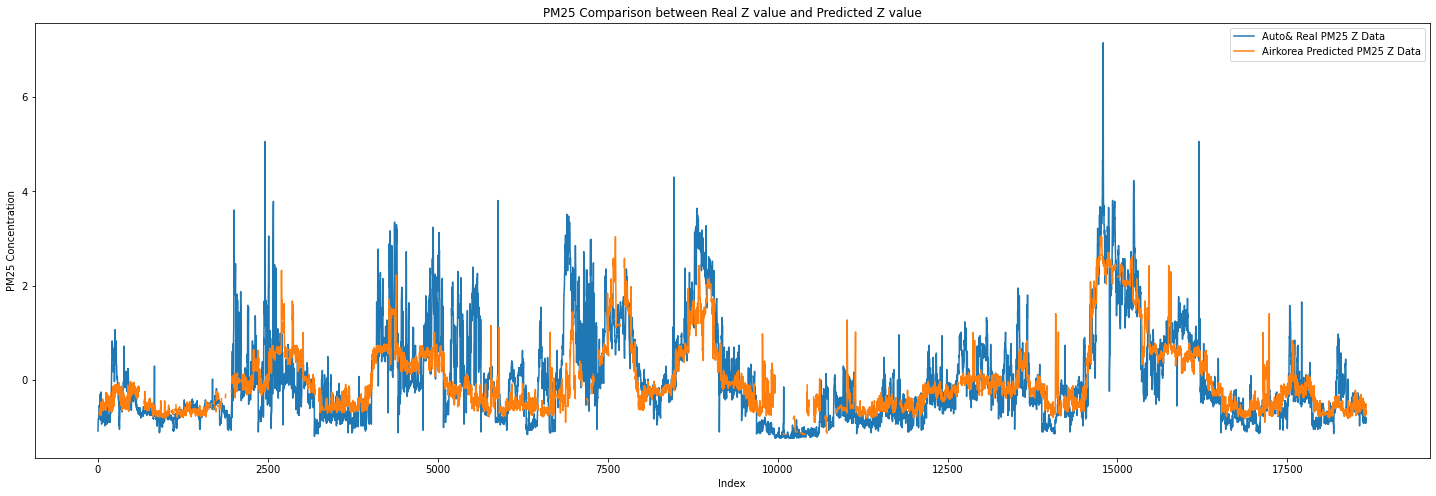

In [8]:
# 차량외부 초미세먼지 농도 데이터 추정 (kNN)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import pickle

X = aligned_pm25.dropna()["airkorea_pm25_z_filtered"]
y = aligned_pm25.dropna()["auton_pm25_z_filtered"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

model = KNeighborsRegressor(n_neighbors=20, algorithm='auto', metric='minkowski', p=2).fit(X_train.to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1,1))
predicted_test = model.predict(X_test.to_numpy().reshape(-1,1))
print("R-squared : {}".format(model.score(X_test.to_numpy().reshape(-1,1), y_test.to_numpy().reshape(-1,1))))
#print("Adjusted R-squared : {}".format(1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)))

knnmodel = open('knn_outcabin', 'wb')
pickle.dump(model, knnmodel) 

# Visualization (kNN)
plt.scatter(X_test, y_test, c='green', label='Testset')
plt.scatter(X_test, predicted_test, c='red', label='Predicted')
plt.rcParams["figure.figsize"] = (25,8)
plt.xlabel("AirKorea PM2.5")
plt.ylabel("Auto& PM2.5")
plt.legend()
plt.title("Auto& PM25 Concentration Prediction")
plt.show()

# apply all data X
predicted_y = model.predict(X.to_numpy().reshape(-1,1))
predicted_y = predicted_y.reshape(-1).tolist()
predicted = pd.Series(predicted_y, index=X.index)

aligned_pm25["auton_pm25_z_predicted"] = predicted
aligned_pm25["auton_pm25_zr_predicted"] = predicted*auton_pm25_std+auton_pm25_mean
print("Data Columns : {}".format(aligned_pm25.columns))
#print(aligned_pm25.head())


# Visualization to compare between real and predicted
plt.plot(aligned_pm25['auton_pm25_z'], label="Auto& Real PM25 Z Data")
plt.plot(aligned_pm25['auton_pm25_z_predicted'], label="Airkorea Predicted PM25 Z Data")
plt.rcParams["figure.figsize"] = (25,8)
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Comparison between Real Z value and Predicted Z value")
plt.show()


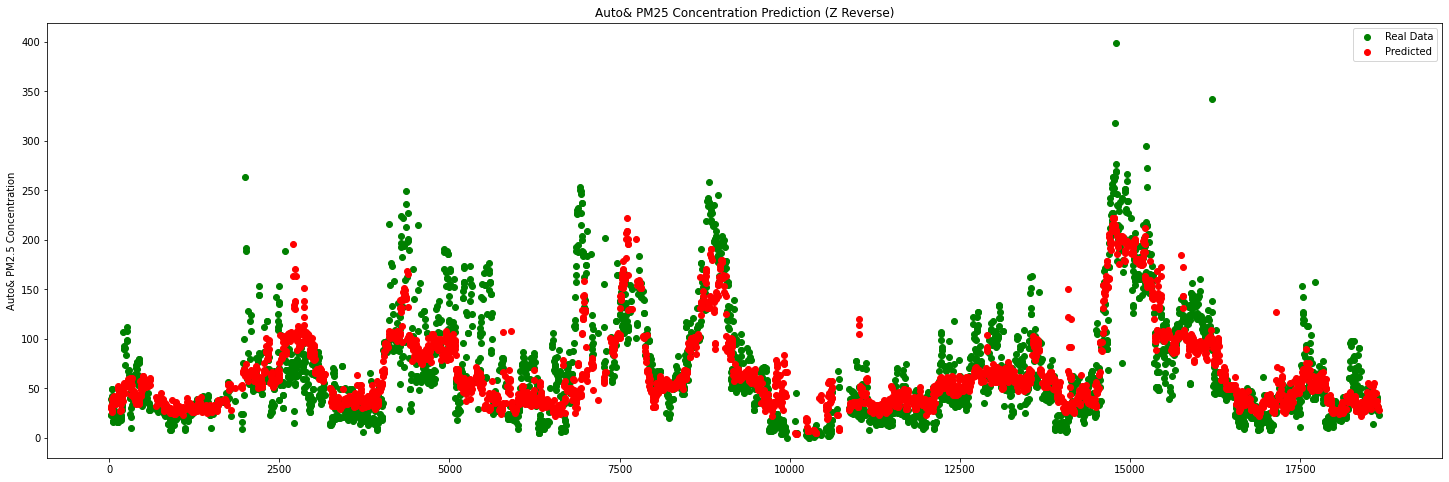

In [6]:
# Out-cabin PM2.5 Prediction Model Verification 
# Z-score reverse

y_test_zr = aligned_pm25["auton_pm25"].iloc[y_test.index.to_list()]
y_test_zr_index = y_test_zr.index.to_numpy()

predicted_y_zr = pd.DataFrame(predicted*auton_pm25_std+auton_pm25_mean, index=y_test_zr_index)

# Visualization (kNN)
plt.scatter(y_test_zr.index.to_list(), y_test_zr, c='green', label='Real Data')
plt.scatter(predicted_y_zr.index.to_list(), predicted_y_zr, c='red', label='Predicted')
plt.rcParams["figure.figsize"] = (25,8)
plt.ylabel("Auto& PM2.5 Concentration")
plt.legend()
plt.title("Auto& PM25 Concentration Prediction (Z Reverse)")
plt.show()


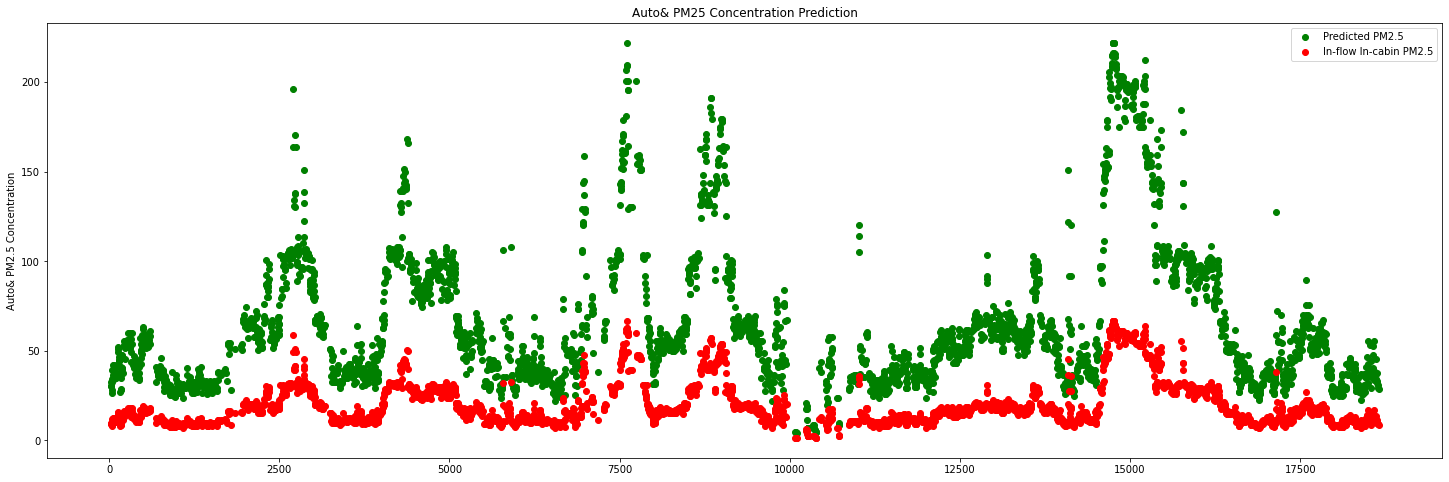

In [7]:
# In-cabin PM2.5 in-flow data scaler
# g(x) = f(x)*(1-c/100)

c = 70 #70% cutoff
incabin_pm25_inflow = predicted_y_zr*(1-c/100)

aligned_pm25["auton_pm25_zr_predicted_inflow"] = aligned_pm25["auton_pm25_zr_predicted"]*(1-c/100)
#print(aligned_pm25.head())

# Visualization (kNN)
plt.scatter(predicted_y_zr.index.to_list(), predicted_y_zr, c='green', label='Predicted PM2.5')
plt.scatter(incabin_pm25_inflow.index.to_list(), incabin_pm25_inflow, c='red', label='In-flow In-cabin PM2.5')
plt.rcParams["figure.figsize"] = (25,8)
plt.ylabel("Auto& PM2.5 Concentration")
plt.legend()
plt.title("Auto& PM25 Concentration Prediction")
plt.show()


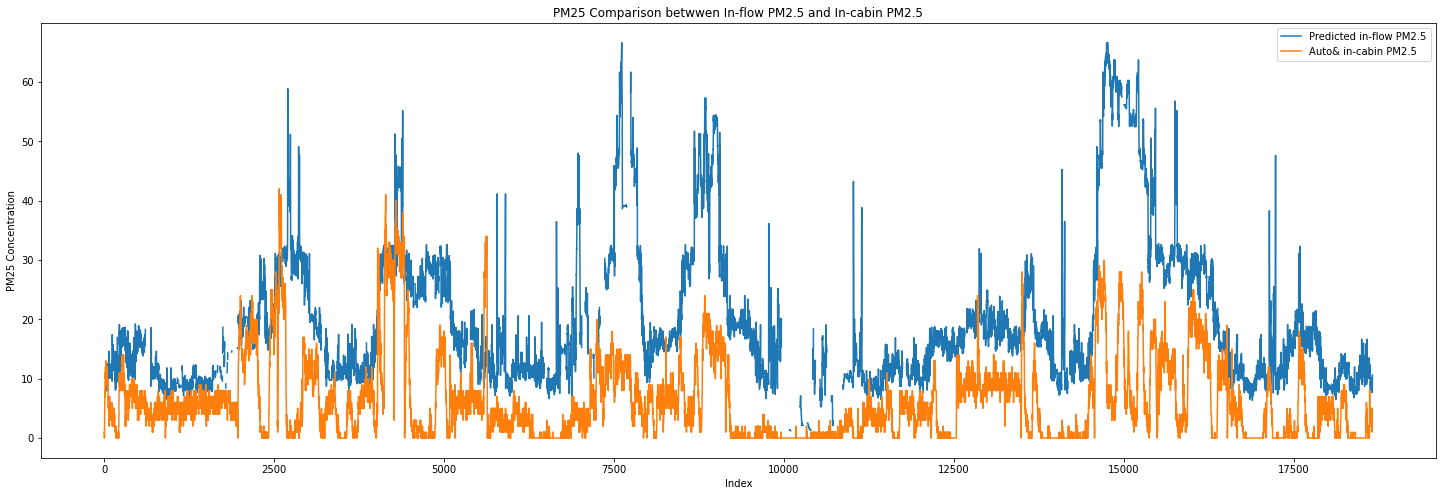

In [8]:
# Comparison between in-flow and in-cabin PM2.5 data

#Visualization (standardization)
plt.plot(aligned_pm25['auton_pm25_zr_predicted_inflow'], label="Predicted in-flow PM2.5")
plt.plot(aligned_pm25['auton_pm25_incabin'], label="Auto& in-cabin PM2.5")
plt.rcParams["figure.figsize"] = (25,8)
plt.xlabel("Index")
plt.ylabel("PM25 Concentration")
plt.legend()
plt.title("PM25 Comparison betwwen In-flow PM2.5 and In-cabin PM2.5")
plt.show()


/Users/byunghunhwang/dev/mlpack/venv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/byunghunhwang/dev/mlpack/venv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/byunghunhwang/dev/mlpack/venv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/byunghunhwang/dev/mlpack/venv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/byunghunhwang/dev/mlpack/venv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0

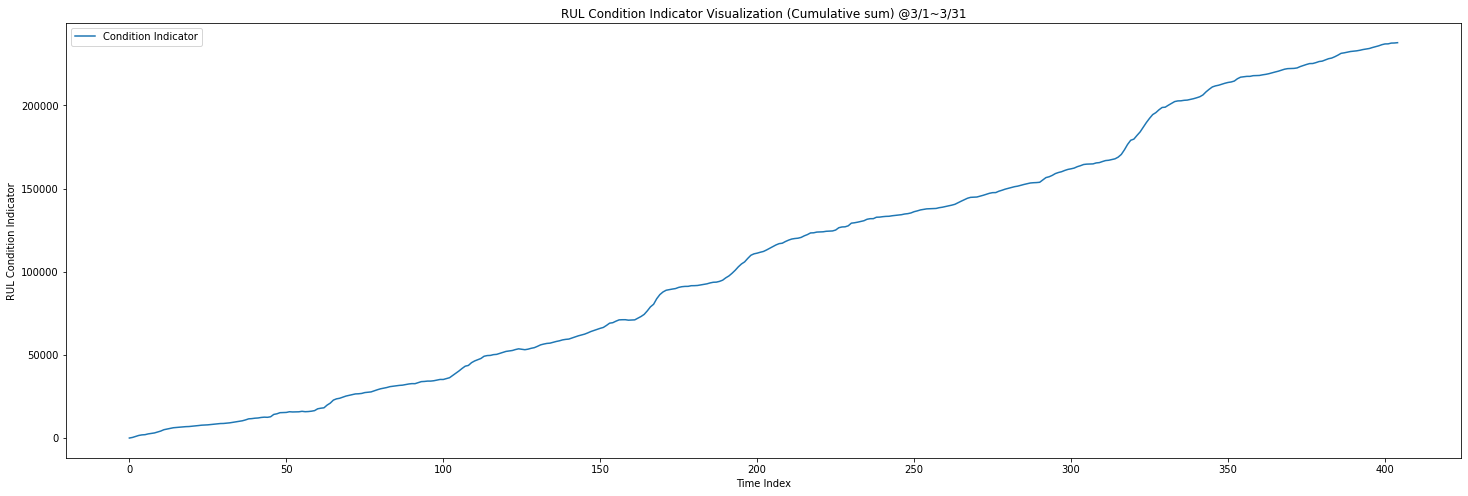

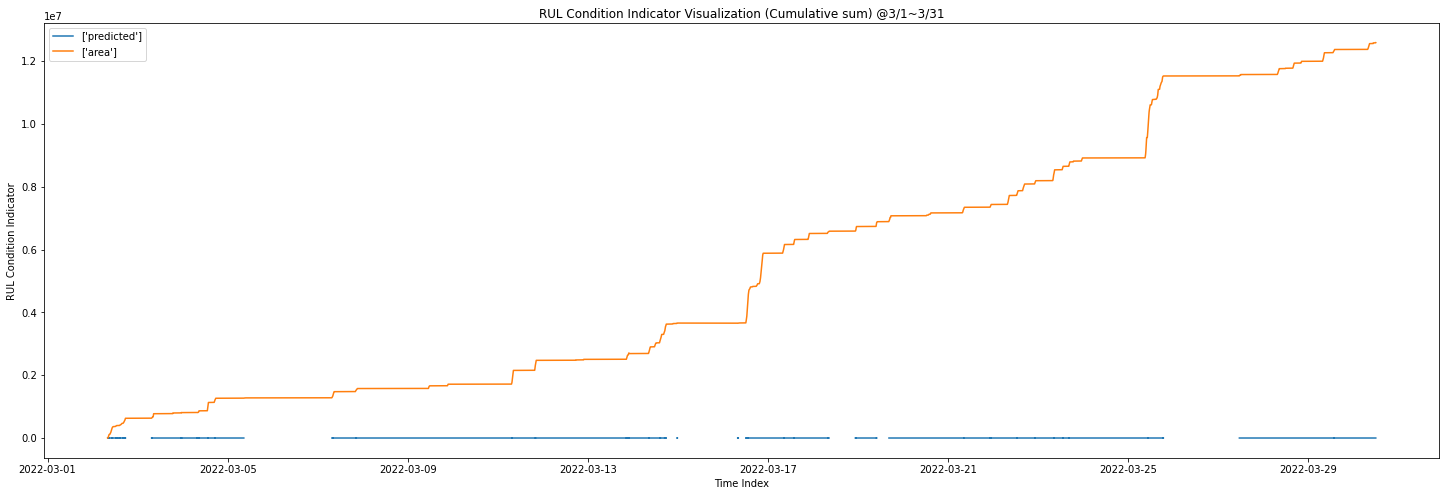

In [276]:
# RUL condition indicator with linear regression (Ordinary Least Square)

from datetime import timedelta
from scipy.stats import linregress
import sympy as sy

# data bin for every hours
t_data = aligned_pm25[["date", 'auton_pm25_zr_predicted_inflow', 'auton_pm25_incabin']]
t_range = pd.date_range(start='2022-03-01',end='2022-04-01', freq='10min')

stack = {}
for start_date in t_range.to_list():
     end_date = start_date + timedelta(minutes=10)
     mask = (t_data['date'] > start_date) & (t_data['date'] <= end_date)

     t_sliced = t_data.loc[mask][['date', 'auton_pm25_zr_predicted_inflow', 'auton_pm25_incabin']]

     if t_sliced.dropna().empty is False:

          y1_data = t_sliced['auton_pm25_zr_predicted_inflow']
          y2_data = t_sliced['auton_pm25_incabin']
          x_data = t_sliced.index

          mask_1 = ~np.isnan(x_data) & ~np.isnan(y1_data)
          mask_2 = ~np.isnan(x_data) & ~np.isnan(y2_data)
          res_1 = stats.linregress(x_data[mask_1], y1_data[mask_1])
          res_2 = stats.linregress(x_data[mask_2], y2_data[mask_2])

          def g(x):
               return res_1.slope*x+res_1.intercept
          def u(x):
               return res_2.slope*x+res_2.intercept

          x = sy.Symbol('x')
          area = sy.integrate(g(x) - u(x), (x, x_data.min(), x_data.max()))
          if area != sy.nan:
               stack[start_date] = area
          
stack_area = pd.DataFrame(data=list(stack.items()), columns=['date', 'area'])
s = stack_area.dropna()
cumsum = stack_area["area"].dropna().cumsum(axis=0)

# Visualization 
plt.plot(cumsum, '-', label='Condition Indicator')
plt.title("RUL Condition Indicator Visualization (Cumulative sum) @3/1~3/31")
plt.xlabel("Time Index")
plt.ylabel("RUL Condition Indicator")
plt.legend()
plt.show()


#visualization (time aligned)
aligned_stack_area = pd.merge_asof(aligned_pm25[["date", 'auton_pm25_zr_predicted_inflow']], s, on='date')
plt.plot(aligned_stack_area['date'], aligned_stack_area["auton_pm25_zr_predicted_inflow"], label='predicted')
plt.plot(aligned_stack_area['date'], aligned_stack_area["area"].dropna().cumsum(axis=0), label='area')
plt.title("RUL Condition Indicator Visualization (Cumulative sum) @3/1~3/31")
plt.xlabel("Time Index")
plt.ylabel("RUL Condition Indicator")
plt.legend()
plt.show()

